# CarND-Advance Lane Detection
***

## Goals and Objectives
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply image distortion
* Finding a thresholded binary image (using gradients and HSV color space)
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and Using sliding window technique to find the lane lines
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import cv2
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

## Camera Calibration
---

Based on the Udacity's camera calibration lecture , built the array of "object points", which holds 3d point  (x, y, z) coordinates of the chessboard corners in the real world.Pass the values of the output `obj_points` and `img_points` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.

The code for the same has been implemented in function `calibrate_camera_matrix()` file _./utils/cameraCalibration.py_

In [2]:
from utils import cameraCalibration

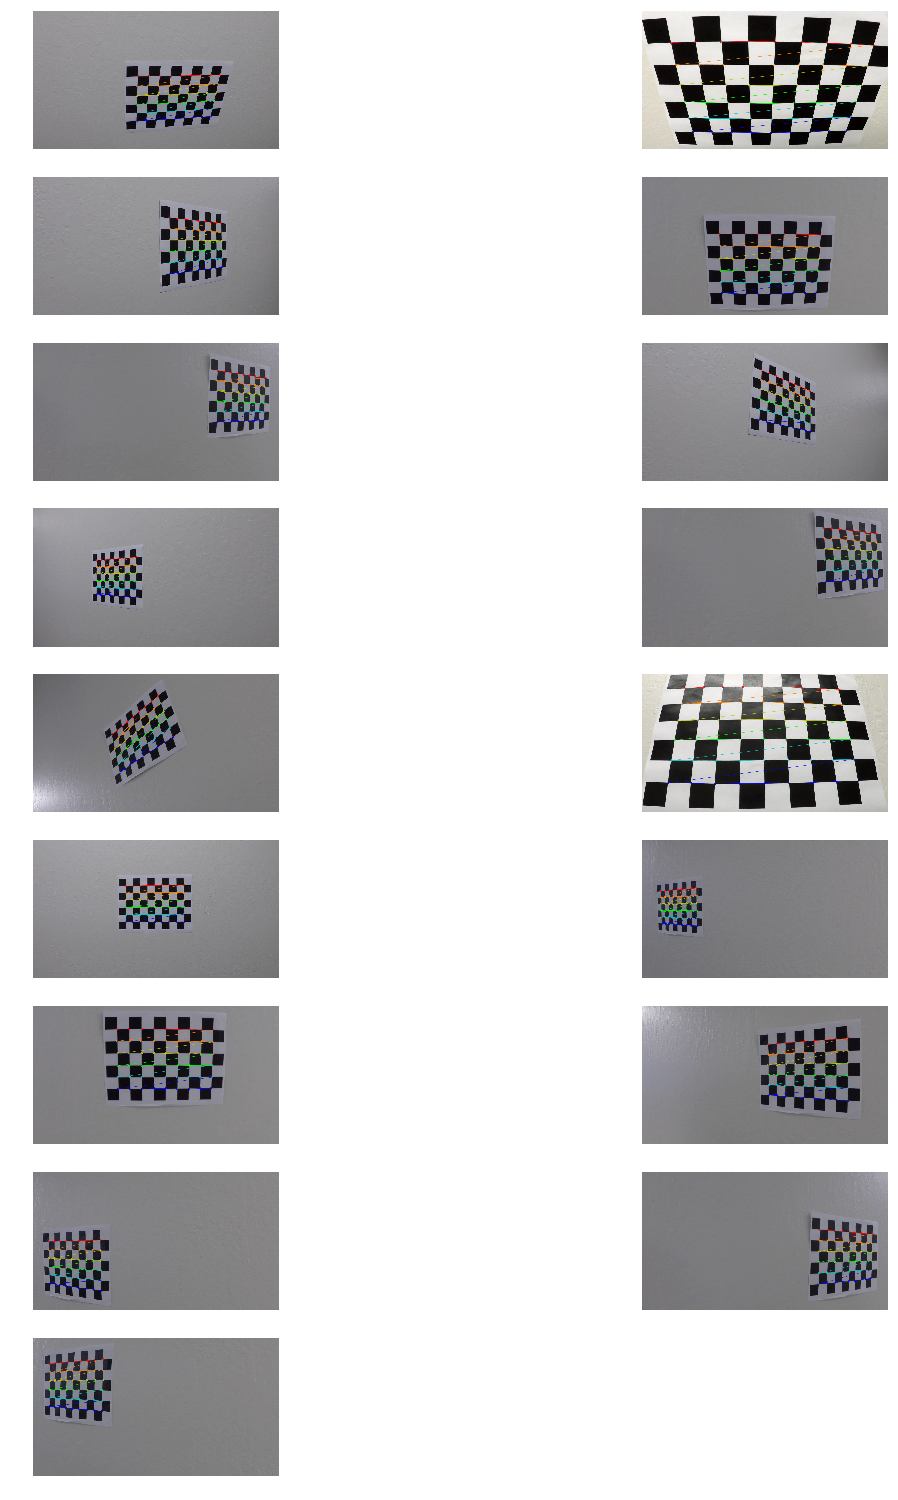

In [3]:
(ret, cameraMat, distCoeffs, rvecs, tvecs), fig = cameraCalibration.calibrate_camera_matrix(os.path.join('camera_cal','*.jpg'))
fig.set_size_inches(20,30)

Use `cv2.undistort` function which is called from `undistort_image()` in _./utils/cameraCalibration.py_) and obtained the following result:

(-0.5, 1279.5, 719.5, -0.5)

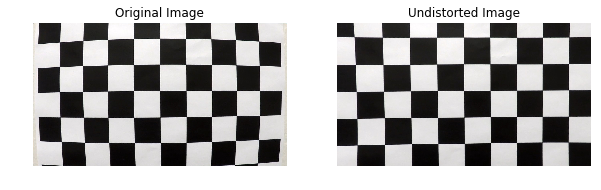

In [4]:
test_image = plt.imread(os.path.join('camera_cal', 'calibration1.jpg'))
undistorted_img = cameraCalibration.undistort_image(test_image, cameraMat, distCoeffs)


plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(test_image)
plt.title('Original Image')
plt.axis("off")

plt.subplot(122)
plt.imshow(undistorted_img)
plt.title('Undistorted Image')
plt.axis("off")




## Pipeline : Start with single image
---

### 1. Undistoring a Image 

Using `cameraMat` and `distCoeffs` found in previous step of camera calibration, the raw image from the video is undistorted using `cv2.undistort` function.For example testing for test3,jpg image

output_images/undistorted_test3.jpg


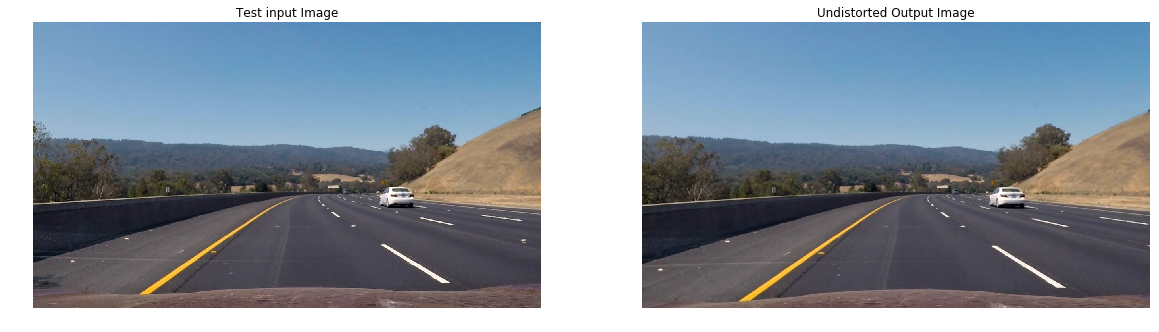

In [5]:
test_image = plt.imread(os.path.join('test_images', 'test3.jpg'))
undistorted_img = cameraCalibration.undistort_image(test_image, cameraMat, distCoeffs)
output_folder = 'output_images'

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(test_image)
plt.title('Test input Image')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(undistorted_img)
plt.title('Undistorted Output Image')
plt.axis("off")

out_file_name = os.path.join(output_folder, "undistorted_test3.jpg")
print(out_file_name)
cameraCalibration.write_image(undistorted_img, out_file_name)


### 2. Apply Binary Threashold
Use `Sobel_Grad_dir_gradient`() (in _./utils/binary_threshold.py_) to threshold white and yellow color pixels from HLS channels and seperate the V channel. 

The following image shows area threshold by yellow mask and red color shows area thresholded by white mask.

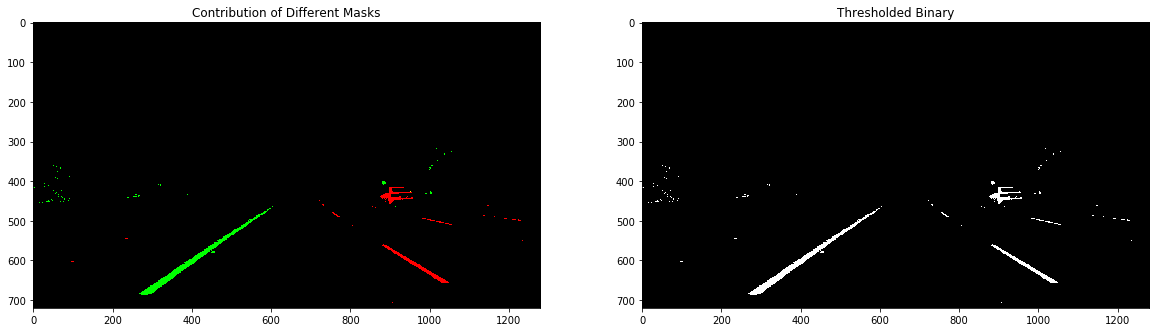

In [6]:
from utils.binary_Threshold import *

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
thresholded = Sobel_Grad_dir_gradient(test_image, color=True)
plt.imshow(thresholded)
plt.title('Contribution of Different Masks')

plt.subplot(1,2,2)
b_thresholded = Sobel_Grad_dir_gradient(test_image)
plt.imshow(b_thresholded, cmap='gray')
plt.title('Thresholded Binary')

### 2. Perspective Transformation
The perspective transformation was done using following source and destination points.

Source Points:
```
 [  588.   446.]
 [  691.   446.]
 [ 1126.   673.]
 [  153.   673.]
```
The output after the perspective transform for the thresholded binary is as shown below:

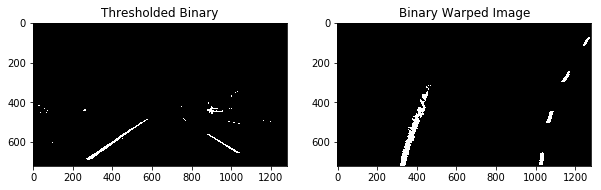

In [7]:
img_size = (b_thresholded.shape[1], b_thresholded.shape[0])
width, height = img_size
offset = 200
src = np.float32([
    [  588,   446 ],
    [  691,   446 ],
    [ 1126,   673 ],
    [  153 ,   673 ]])
dst = np.float32([[offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]], [offset, img_size[1]]])
Xform_Matrix = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst, src)

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
b_thresholded = Sobel_Grad_dir_gradient(test_image)
plt.imshow(b_thresholded, cmap='gray')
plt.title('Thresholded Binary')

plt.subplot(1,2,2)
binary_warped = cv2.warpPerspective(b_thresholded,Xform_Matrix, (width, height))
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped Image')

### 3. Lane Detections
I am adding up the pixel values along each column in the image. In my thresholded binary image, pixels are either 0 or 1, so the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines.
Once one of the first frames is processed, I use the last known line location to restrict the search for new lane pixels. The code for the same can be found in _./utils/pipeline.py_.

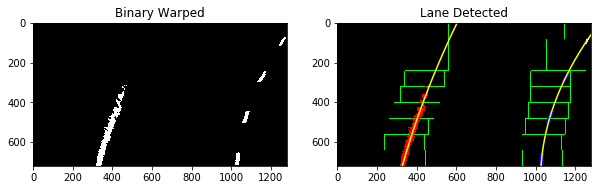

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

        
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Finding peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Number of sliding windows
nwindows = 9

# Height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identifing the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])


# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Margin in which to search
margin = 100

# Minimum number of pixels found to recenter window
minpix = 50

# Empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Steping through windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Drawing the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identifing the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Appending these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # Recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenating the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extracting left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 


# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

## Visualization
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped')

plt.subplot(1,2,2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Lane Detected')

### 3. Radius of Curvature
If real-world corrdinate (subscript x<sub>real</sub> and y<sub>real</sub>) are related to coordinate in pixel space (x<sub>pix</sub> and y<sub>pix</sub>) by some multiplier,Use the reference from the lecture.
The radius of curvature (awesome tutorial here) at any point x of the function x=f(y) is given as follows:

R​curve​​=​∣​dy​2​​​​d​2​​x​​∣​​[1+(​dy​​dx​​)​2​​]​3/2​​​​

In the case of the second order polynomial above, the first and second derivatives are:

f​′​​(y)=​dy​​dx​​=2Ay+B

f​′′​​(y)=​dy​2​​​​d​2​​x​​=2A

So, our equation for radius of curvature becomes:

R​curve​​=​∣2A∣​​(1+(2Ay+B)​2​​)​3/2​​​​

Make use of the Measuring Curvature topic from the course.


In [9]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
y_eval = 700
midx = 650

y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
print("Curve radius: %f" % curvature)

Curve radius: 1173.941023


### 4. Warp the detected lane boundaries back onto the original image.

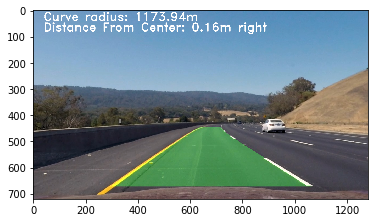

In [10]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)

cv2.putText(result,'Curve radius: %.2fm' % curvature,(40,40), cv2.FONT_HERSHEY_DUPLEX, 1.5,(255,255,255),2, cv2.LINE_AA)

x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
position_from_center = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
if position_from_center < 0:
    text = 'left'
else:
    text = 'right'
cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(40,80), cv2.FONT_HERSHEY_DUPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)
plt.imshow(result)

# Final Video
---
For implemetation details check `./utils/line.py`.


In [11]:
from utils.pipeline import Pipeline
from utils.line import Line
from moviepy.editor import VideoFileClip
from IPython.display import HTML

line=Line()
Pipeline.set_param(line, Xform_Matrix, Minv, cameraMat, distCoeffs)

white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(Pipeline.pipeline)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [01:30<00:00, 14.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 7min 44s, sys: 1.41 s, total: 7min 45s
Wall time: 1min 31s


# Discussion and references
---
The code does not perform well on challenge videos due to varied illumination color shades in challenge videos.
For further research I plan to refine my pipeline to work in more varied environments and nomralization of the image.

References:

1) More robust lane finding using advanced computer vision techniques
   https://chatbotslife.com/robust-lane-finding-using-advanced-computer-vision-techniques-46875bb3c8aa
   
2) Camera calibration With OpenCV:
   https://docs.opencv.org/2.4/doc/tutorials/calib3d/camera_calibration/camera_calibration.html
   
3) Radius curvature: http://www.intmath.com/applications-differentiation/8-radius-curvature.php   

4) https://github.com/Nallo/CarND-P4-Advanced-Lane-Lines

5) https://medium.com/@ajsmilutin/advanced-lane-finding-5d0be4072514